In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from scipy.optimize import curve_fit
import datetime
from statsmodels.stats.multitest import multipletests
from cedne import utils
import cedne
import pywt
import copy
import tensorly
from tensorly.decomposition import parafac
from tensorly import partial_svd
from tensorly import transpose as tl_transpose
from tensorly.decomposition import tucker
from tensorly.tenalg import multi_mode_dot
from tensorly.tenalg import mode_dot
from tensorly import kruskal_to_tensor
from tensorly import tensor
from tensorly import unfold
from tensorly import fold
from tensorly import concatenate as tl_concatenate
from tensorly.tenalg import svd_interface
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
tensorly.set_backend('pytorch')
import torch
import plotly.graph_objs as go
from typing import List, Dict, Tuple, Any, Callable
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
matplotlib.__version__

'3.10.5'

In [3]:
today = str(datetime.datetime.now()).split(' ')[0]
outputDir = "Output/" + today + "/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

num_timepoints = 450
genotypes = ['N2', 'inx-7-mutant', 'inx-7-rescue']
conds = ['naive', 'trained']
stimuli = ['OP-PA-OP', 'OP-Buffer-OP', 'Buffer-PA-Buffer', 'Buffer-Buffer-Buffer', 'OP-gacA-OP']
promoters = ['ncs-1', 'inx-4', 'glr-1', 'acr-5', 'inx-4+mbr-1', 'flp-3p+flp-7p+nmr-1p+sro-1p', 'odr-2(2b)+odr-2(18)p']
promoter_names = {
    'glr-1': 'inter-motor group',
    'ncs-1': 'sensory-inter group I',
    'inx-4': 'sensory-inter group II',
    'inx-4+mbr-1': 'sensory-inter group III',
    'acr-5': 'sensory-inter-motor group I',
    'odr-2(2b)+odr-2(18)p': 'sensory-inter-motor group II',
    'flp-3p+flp-7p+nmr-1p+sro-1p': 'sensory-inter-motor group III'
    }

In [4]:
single_column = 90
double_column = 180
max_height = 170
font_size_big = 7 #pts
font_size_mid = 6
font_size_small = 5
DPI = 600

In [5]:
def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

In [8]:
picklefile = "../..//whole-brain-learning/Output/2025-12-24/worm_tensors.pickle"

with open(picklefile, 'rb') as f:
    all_neurs_set, worm_tensors_ori, worm_tensors = pickle.load(f)

In [10]:
def makeBinaryMask(tensor):
    # Create a binary mask based on the tensor values
    mask = np.ones(tensor.shape, dtype=bool)
    mask[np.isnan(tensor)] = 0
    return mask

In [19]:
color_stim = {'OP': '#e4ab24',
              'PA': '#1a9d77',
              'Buffer': '#f9f4d7'}
color_conds = {'naive': '#888666',
               'trained': '#6b3e98', 
               'gacA-trained': "#7a1652"}

## Getting common temporal factors across OP-PA and Buffer-PA.

In [ ]:
def get_common_worm_counts(worm_tensors, conds=('naive', 'trained'), common_length=9, promoter_exceptions=None):
    """
    Computes the minimum number of worms per genotype × stimulus that are available across promoters.

    Args:
        worm_tensors (dict): Nested dictionary [genotype][promoter][stimulus][condition] → tensor
        conds (tuple): Conditions to consider (default: ('naive', 'trained'))
        common_length (int): Initial high value to start min() comparisons
        promoter_exceptions (list or set): Promoters to skip

    Returns:
        sampleNum (dict): [genotype][stimulus] → min worm count across conditions and promoters
    """
    if promoter_exceptions is None:
        promoter_exceptions = set()
    else:
        promoter_exceptions = set(promoter_exceptions)

    sampleNum = {}
    learningNum = {}

    for genotype in worm_tensors:
        sampleNum[genotype] = {}
        learningNum[genotype] = {}
        for promoter in worm_tensors[genotype]:
            learningNum[genotype][promoter] = {}
            if promoter in promoter_exceptions:
                continue
            for stimulus in worm_tensors[genotype][promoter]:
                # Initialize if not already present
                if stimulus not in learningNum[genotype][promoter]:
                    learningNum[genotype][promoter][stimulus] = {}
                if stimulus not in sampleNum[genotype]:
                    sampleNum[genotype][stimulus] = common_length

                # Check both conditions exist
                if all(cond in worm_tensors[genotype][promoter][stimulus] for cond in conds):
                    n_naive = worm_tensors[genotype][promoter][stimulus][conds[0]].shape[2]
                    n_trained = worm_tensors[genotype][promoter][stimulus][conds[1]].shape[2]
                    sampleNum[genotype][stimulus] = min(sampleNum[genotype][stimulus], n_naive, n_trained)

                    print(f"{genotype} {promoter} {stimulus} — Naive: {n_naive}, Trained: {n_trained}")
                    learningNum[genotype][promoter][stimulus]['naive'] = n_naive
                    learningNum[genotype][promoter][stimulus]['trained'] = n_trained

    return sampleNum, learningNum

def convert_worm_tensors_with_masks_no_common_num(worm_tensors, all_neurs_set, num_timepoints,
                                     conds=('naive', 'trained'), promoter_exceptions=None):
    """
    Converts worm_tensors into standardized tensors with masks for decomposition,
    subsampling worms and flattening for masking.

    Args:
        worm_tensors (dict): Nested dict [genotype][promoter][stimulus][cond] -> ndarray (neurons x time x worms)
        all_neurs_set (dict): [genotype][promoter][stimulus] -> list of neuron indices to keep
        conds (tuple): Conditions to use (default: ('naive', 'trained'))
        promoter_exceptions (list or set): Promoters to skip

    Returns:
        worm_tensors_converted (dict): [genotype][promoter][stimulus] -> standardized tensor (neurons x time x worms)
        masks (dict): Same structure as above; binary mask tensors
    """
    if promoter_exceptions is None:
        promoter_exceptions = set()
    else:
        promoter_exceptions = set(promoter_exceptions)

    worm_tensors_converted = {}
    masks = {}

    for genotype in worm_tensors:
        worm_tensors_converted[genotype] = {}
        masks[genotype] = {}
        for promoter in worm_tensors[genotype]:
            if promoter in promoter_exceptions:
                continue
            worm_tensors_converted[genotype][promoter] = {}
            masks[genotype][promoter] = {}
            for stimulus in worm_tensors[genotype][promoter]:

                print(genotype, promoter, stimulus)
                num_neurons = len(all_neurs_set[genotype][promoter][stimulus])
                num_worms = worm_tensors[genotype][promoter][stimulus]['naive'].shape[2] + worm_tensors[genotype][promoter][stimulus]['trained'].shape[2]
                bigmat = np.empty((num_neurons, num_timepoints, num_worms))
                j = 0

                for cond in conds:
                    worms_available = worm_tensors[genotype][promoter][stimulus][cond].shape[2]
                    for i in range(worms_available):
                        bigmat[:, :, j] = worm_tensors[genotype][promoter][stimulus][cond][:, :, i]
                        j += 1

                reshaped = bigmat.reshape((-1, bigmat.shape[-1]))  # neurons*time × worms

                # Mask
                binary_mask = makeBinaryMask(reshaped)
                masks[genotype][promoter][stimulus] = torch.tensor(binary_mask.reshape(bigmat.shape))

                # Standardize (optional — with_mean=False to preserve scale)
                # scaler = StandardScaler(with_mean=False)
                # scaler = StandardScaler(with_mean=True)
                # scaled = scaler.fit_transform(reshaped)
                scaled = reshaped 

                scaled_tensor = torch.tensor(scaled.reshape(bigmat.shape))
                worm_tensors_converted[genotype][promoter][stimulus] = scaled_tensor

    return worm_tensors_converted, masks

def pick_only_stim_periods(worm_tensors, stim_period=(0,450)):
    worm_tensors_clean= {}
    for genotype in worm_tensors:
        worm_tensors_clean[genotype] = {}
        for promoter in worm_tensors[genotype]:
            worm_tensors_clean[genotype][promoter] = {}
            for stimulus in worm_tensors[genotype][promoter]:
                worm_tensors_clean[genotype][promoter][stimulus] = {} 
                for cond in worm_tensors[genotype][promoter][stimulus]: 
                    worm_tensors_clean[genotype][promoter][stimulus][cond] =  worm_tensors[genotype][promoter][stimulus][cond][:,stim_period[0]:stim_period[1], :]
    return worm_tensors_clean

In [13]:
promoter_exceptions = [] #['flp-3p+flp-7p+nmr-1p+sro-1p']
common_length = 9
stim_period=(150,450)
num_timepoints = stim_period[1]-stim_period[0]
worm_tensors_stimonly = pick_only_stim_periods(worm_tensors, stim_period = stim_period) 
sampleNum, learnNum = get_common_worm_counts(worm_tensors_stimonly, common_length=common_length, promoter_exceptions=promoter_exceptions)
#                                                               conds=('naive', 'trained'), promoter_exceptions=promoter_exceptions)
worm_tensors_converted, _ = convert_worm_tensors_with_masks_no_common_num(worm_tensors_stimonly, all_neurs_set, num_timepoints,
                                                                   conds=('naive', 'trained'), promoter_exceptions=promoter_exceptions)

worm_tensors_ori_stimonly = pick_only_stim_periods(worm_tensors_ori, stim_period = stim_period) 
_, masks = convert_worm_tensors_with_masks_no_common_num(worm_tensors_ori_stimonly, all_neurs_set, num_timepoints,
                                                                   conds=('naive', 'trained'), promoter_exceptions=promoter_exceptions)

N2 ncs-1 OP-PA-OP — Naive: 19, Trained: 20
N2 ncs-1 OP-Buffer-OP — Naive: 14, Trained: 17
N2 ncs-1 Buffer-PA-Buffer — Naive: 20, Trained: 21
N2 ncs-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 ncs-1 OP-gacA-OP — Naive: 14, Trained: 16
N2 inx-4 OP-PA-OP — Naive: 22, Trained: 23
N2 inx-4 Buffer-PA-Buffer — Naive: 21, Trained: 21
N2 glr-1 OP-PA-OP — Naive: 25, Trained: 22
N2 glr-1 Buffer-PA-Buffer — Naive: 19, Trained: 26
N2 glr-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 acr-5 OP-PA-OP — Naive: 20, Trained: 22
N2 acr-5 Buffer-PA-Buffer — Naive: 15, Trained: 17
N2 acr-5 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 inx-4+mbr-1 OP-PA-OP — Naive: 25, Trained: 24
N2 inx-4+mbr-1 Buffer-PA-Buffer — Naive: 15, Trained: 19
N2 inx-4+mbr-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 9
N2 flp-3p+flp-7p+nmr-1p+sro-1p OP-PA-OP — Naive: 22, Trained: 19
N2 flp-3p+flp-7p+nmr-1p+sro-1p Buffer-PA-Buffer — Naive: 22, Trained: 17
N2 odr-2(2b)+odr-2(18)p OP-PA-OP — Naive: 22, Trained: 21
N2 od

## Common Temporal Basis

In [14]:
common_length = 20
R_t = 6
stimulus_filter = [
    'OP-PA-OP',
 'Buffer-PA-Buffer'
]
genotype_filter = ['N2']
common_over_promoters_tensor = {}
unfolded_masks = {}
common_all = []
masks_all = []
for genotype in worm_tensors:
# for genotype in worm_tensors_converted:
    if genotype in genotype_filter: #
        common_over_promoters_tensor[genotype] = {}
        unfolded_masks[genotype] = {}
        for promoter in worm_tensors_converted[genotype]:
            for stimulus in worm_tensors_converted[genotype][promoter]:
                if stimulus in stimulus_filter:
                    if not stimulus in common_over_promoters_tensor[genotype].keys():
                        common_over_promoters_tensor[genotype][stimulus] = []
                        unfolded_masks[genotype][stimulus] = []
                    common_over_promoters_tensor[genotype][stimulus].append(unfold(worm_tensors_converted[genotype][promoter][stimulus], mode=1))
                    unfolded_masks[genotype][stimulus].append(unfold(masks[genotype][promoter][stimulus], mode=1))
                    common_all.append(unfold(worm_tensors_converted[genotype][promoter][stimulus], mode=1))
                    masks_all.append(unfold(masks[genotype][promoter][stimulus], mode=1))

common_all_pre = tl_concatenate(common_all, axis=1)
masks_all = tl_concatenate(masks_all, axis=1)


scaler = StandardScaler(with_mean=False)
# scaler = StandardScaler(with_mean=True)
common_all = torch.tensor(scaler.fit_transform(common_all_pre))

if masks_all.dtype == torch.bool:
    masks_all = masks_all.float()

svd = svd_interface(
            common_all,
            n_eigenvecs=R_t,
            random_state=cedne.RANDOM_SEED,
            return_eigenvectors=True,
            mask = masks_all,
            n_iter_mask_imputation=3
        )

common_temporal_basis = {}
for genotype in worm_tensors_converted:
    common_temporal_basis[genotype] = {}
    for stimulus in stimuli: #Since this is common over genotypes and stimuli
        common_temporal_basis[genotype][stimulus] = svd[0] 
# common_temporal_basis = svd[0]
common_singular_values = svd[1]  # shape (R_t,)

# Variance explained calculation
singular_values_squared = common_singular_values ** 2

total_data_variance = torch.sum(common_all ** 2)

total_variance = torch.sum(singular_values_squared)
variance_explained = singular_values_squared / total_data_variance  # shape (R_t,)
print("Variance explained per temporal component:")
print(variance_explained)
print("Cumulative variance explained:")
print(torch.cumsum(variance_explained, dim=0))
print("Shape of common tensor:", common_all.shape)

Variance explained per temporal component:
tensor([0.7498, 0.1114, 0.0400, 0.0228, 0.0125, 0.0097], dtype=torch.float64)
Cumulative variance explained:
tensor([0.7498, 0.8612, 0.9011, 0.9240, 0.9365, 0.9461], dtype=torch.float64)
Shape of common tensor: torch.Size([300, 7234])


In [15]:
common_all_pre.shape

torch.Size([300, 7234])

In [16]:
temporal_components= common_temporal_basis['N2']['OP-PA-OP']

In [17]:
common_all_pre.shape[0]* common_all_pre.shape[1]

2170200

## Fig. 2b

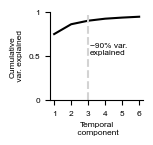

In [ ]:
figsize = mm_to_inches((single_column/2.5, max_height/5))
f, ax = plt.subplots(figsize=figsize, layout='constrained')
ax.plot(torch.cumsum(variance_explained, dim=0), color='k')
# ax.axhline(0.92, color='gray', linestyle='--')
ax.axvline(x=2, color='lightgray', linestyle='--')
ax.text(2.1,0.58, '~90% var. \nexplained', ha='left', va='center', fontsize=font_size_mid)
utils.simpleaxis(ax)
ax.set_yticks([0, 0.5, 1], [0, 0.5, 1], fontsize=font_size_mid)
ax.set_xticks(range(0, R_t), [str(i) for i in range(1, R_t+1)], fontsize=font_size_mid)
ax.set_ylabel('Cumulative\n var. explained', fontsize=font_size_mid)
ax.set_xlabel('Temporal\n component', fontsize=font_size_mid)
# ax.set_title(f"{genotype} {stimulus}")
plt.savefig("figures/variance_explained_cumulative_temporal.svg", transparent=True)
plt.show()

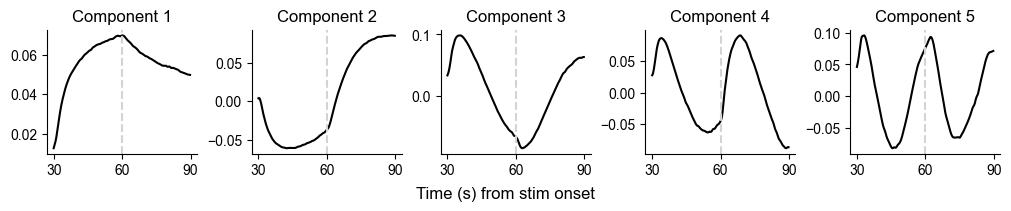

In [20]:
# %matplotlib widget
chosen_compnum = 5
f, ax = plt.subplots(figsize=(2*chosen_compnum,2), ncols=chosen_compnum, sharex=True, layout='constrained')
for i in range(chosen_compnum):
    ax[i].plot(common_temporal_basis['N2']['OP-PA-OP'][:,i], color='k')
    utils.simpleaxis(ax[i])
    ax[i].set_title(f'Component {i+1}')
# ax.plot(common_temporal_basis[genotype][stimulus][:,:5])
    ax[i].axvline(x=150, color='lightgray', linestyle='--')
    # ax[i].axvline(x=300, color='lightgray', linestyle='--')
    ax[i].set_xticks([0,150,300], [30,60,90])
f.supxlabel("Time (s) from stim onset")
plt.show()

In [21]:
temporal_components = common_temporal_basis['N2']['OP-PA-OP'].detach().numpy()  # shape: T × n_components

In [ ]:
import numpy as np
from numpy.linalg import solve, eig
import numpy as np, matplotlib.pyplot as plt, networkx as nx
from matplotlib.patches import FancyArrowPatch
import cvxpy as cp

def to_np(x):
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def finite_diff(X, dt=1.0):
    return (X[1:] - X[:-1]) / dt

def fit_lds_sparse(C, U, lamA=1e-2, lamB=1e-2, lamL2=1e-3, dt=1.0):
    Cdot = (C[1:] - C[:-1]) / dt          # (T-1, r)
    Cmid, Umid = C[:-1], U[:-1]           # (T-1, r), (T-1, m)
    r, m = C.shape[1], U.shape[1]

    A = cp.Variable((r, r))
    B = cp.Variable((r, m))               # <-- r x m

    pred = Cmid @ A.T + Umid @ B.T        # (T-1, r)
    loss = 0.5*cp.sum_squares(Cdot - pred)
    reg  = lamA*cp.norm1(A) + lamB*cp.norm1(B) + lamL2*(cp.sum_squares(A)+cp.sum_squares(B))
    prob = cp.Problem(cp.Minimize(loss + reg))
    prob.solve(solver=cp.SCS, verbose=False)  # SCS handles L1 well

    return A.value, B.value

def simulate_lds(C0, U, A, B, dt=1.0):
    """
    C0: (r,) initial state; U: (T, m)
    Returns Csim: (T, r)
    """
    T, m = U.shape
    r = C0.size
    Csim = np.zeros((T, r))
    Csim[0] = C0
    for t in range(T-1):
        Csim[t+1] = Csim[t] + dt * (Csim[t] @ A.T + (B @ U[t]).T)
    return Csim

def _as_matrix_stack(A_boot):
    A_boot = np.asarray(A_boot)
    if A_boot.ndim == 2:
        # single (r,r)
        return A_boot[None, ...]
    if A_boot.ndim == 1:
        # flattened -> try square reshape
        n = int(np.sqrt(A_boot.size))
        assert n*n == A_boot.size, "A is 1D but not square when reshaped."
        return A_boot.reshape(1, n, n)
    if A_boot.ndim == 3:
        return A_boot
    raise ValueError("A_boot must be (r,r), (B,r,r), or flat length r*r.")

def edges_from_A(A_boot, thresh=0.1, sign_pmin=0.8):
    A_stack = _as_matrix_stack(A_boot)          # (B,r,r)
    A_mean  = A_stack.mean(0)                   # (r,r)
    r = A_mean.shape[0]

    # normalize off-diagonals by self-decay
    G = A_mean.copy()
    for j in range(r):
        denom = abs(A_mean[j, j]) + 1e-12
        G[:, j] = G[:, j] / denom
        G[j, j] = 0.0

    # sign stability
    if A_stack.shape[0] == 1:
        sign_prob = np.ones_like(A_mean)
    else:
        sign_prob = (np.sign(A_stack) == np.sign(A_mean)[None, :, :]).mean(0)

    mask = (np.abs(G) >= thresh) & (sign_prob >= sign_pmin)
    return G, sign_prob, mask

def input_edges_from_B(B_boot, thresh=0.1, sign_pmin=0.8):
    B_boot = np.asarray(B_boot, float)
    if B_boot.ndim == 2:           # (r,m)
        B_stack = B_boot[None, ...]  # (1,r,m)
    elif B_boot.ndim == 3:         # (B,r,m)
        B_stack = B_boot
    else:
        raise ValueError(f"B must be (r,m) or (B,r,m), got {B_boot.shape}")

    B_mean = B_stack.mean(0)       # (r,m)
    r, m = B_mean.shape
    norms = np.linalg.norm(B_mean, axis=0, keepdims=True) + 1e-12  # (1,m)
    Gin = B_mean / norms           # (r,m)
    assert Gin.ndim == 2 and Gin.shape == (r, m), f"Gin bad shape {Gin.shape}"

    if B_stack.shape[0] == 1:
        sign_prob = np.ones_like(B_mean)   # (r,m)
    else:
        sign_prob = (np.sign(B_stack) == np.sign(B_mean)[None,:,:]).mean(0)

    mask = (np.abs(Gin) >= thresh) & (sign_prob >= sign_pmin)  # (r,m)
    return Gin, sign_prob, mask

def curved_arrow(ax, pos, u, v, rad, width, style, color="k",
                 shrink=18, ms=18, z=3):
    a = FancyArrowPatch(pos[u], pos[v],
                        connectionstyle=f"arc3,rad={rad}",
                        arrowstyle='-|>', mutation_scale=ms,
                        lw=width, linestyle=style, color=color,
                        shrinkA=shrink, shrinkB=shrink, clip_on=False)
    a.set_zorder(z)
    ax.add_patch(a)

def draw_bidirected(G_norm, thres=0.3, labels=("1","2","3"), node_size=600, save=False):
    mask = (np.abs(G_norm)>thres)
    n = G_norm.shape[0]
    G = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            if i!=j and mask[i,j]:
                G.add_edge(j,i, w=float(abs(G_norm[i,j])), s=float(np.sign(G_norm[i,j])))

    pos = nx.spring_layout(G, seed=0)
    figsize = mm_to_inches((single_column/2, single_column/2))
    fig, ax = plt.subplots(figsize=figsize, layout='constrained')
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_size, ax=ax)#, zorder=2)
    nx.draw_networkx_labels(G, pos, labels={i:l for i,l in enumerate(labels)}, ax=ax, font_size=font_size_mid)#, zorder=4)

    # draw each directed edge; if the reverse exists, curve them opposite ways
    for u,v,d in G.edges(data=True):
        both = G.has_edge(v,u) and G.has_edge(u,v)
        if both and u < v:
            rad = 0.55
        # elif both and d['s']<0:
        #     rad = 0.
        else:
            rad = 0.
        # rad = 0.55 if both and (u < v) else -0.55 if both else 0.25
        style = 'solid' if d['s']>=0 else 'dashed'
        color = 'tab:blue' if d['s']>=0 else 'tab:red'
        width =  d['w'] + 1.2
        curved_arrow(ax, pos, u, v, rad=rad, width=width, style=style,
                     shrink=np.sqrt(node_size), ms=3*width, color=color)

    # ax.set_title("LDS Interaction Graph (column → row)")
    ax.set_axis_off()
    if not save == False:
        plt.savefig(save, transparent=True)
    plt.show()

def plot_sim_vs_data(C, Csim, save=False, fontsize=font_size_big):
    corrs = [np.corrcoef(C[:,k], Csim[:,k])[0,1] for k in range(C.shape[1])]
    figsize = mm_to_inches((single_column, max_height/5))
    f, ax = plt.subplots(figsize=figsize, ncols=C.shape[1], layout='constrained', sharex=True, sharey=True)
    for k in range(C.shape[1]):
        l1, = ax[k].plot(C[:,k], label='data', color='k')
        l2, = ax[k].plot(Csim[:,k], label='fit', color='cyan', alpha=0.7)
        ax[k].set_title(f'PC {k+1}, r={corrs[k]:.3f}')
        utils.simpleaxis(ax[k])
        ax[k].axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax[k].axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax[k].axvline(150, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax[k].set_xticks([0, 150, 300], [30, 60, 90], fontsize=fontsize)
        ax[k].set_yticks([-1, 0, 1], [-1, 0, 1], fontsize=fontsize)
        if k == 0:
            lines = [l1, l2]
        utils.simpleaxis(ax[k])
        ax[k].annotate(xy= (155,1.5), text=f'TC{k+1}', va='center', ha='left', fontsize=fontsize)
    ax[0].set_ylabel("Component value", fontsize=fontsize, ha='center')
    f.supxlabel("Time (s)", fontsize=fontsize)
    f.legend(handles=lines, loc='upper left', fontsize=fontsize, frameon=False, bbox_to_anchor=(1.05, 0.15), ncol=2)
    if save:
        plt.savefig("figures/lds_fit_temporal_components.svg", bbox_inches='tight', transparent=True, dpi=DPI)
    plt.show()

1


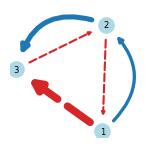

[ 6.73127356 18.12924558 18.12924558]


In [24]:
chosen_compnum = 3 
C = common_temporal_basis["N2"]["OP-PA-OP"][:,:chosen_compnum]

T, r = C.shape
Sigma = (C.T @ C) / T 
W = np.linalg.inv(np.linalg.cholesky(Sigma))  
C = C @ W.T                         # (1/T) C_canon^T C_canon = I

node_size = 120

lamA = 1e-3   # sparsity on A
lamB = 1e-3   # sparsity on B
lamL2 = 1e-3  # small weights
dt = 0.2
# Build U (T×m) with your inputs (e.g., OP, PA) for the same condition:
u_op = np.zeros(T); u_pa = np.zeros(T)
u_pa[:T//2] = 1.0; u_op[T//2:] = 1.0  # adjust to your epochs
U = np.column_stack([u_op, u_pa])   # m=2 (add buffer channel if used)

C = to_np(C).astype(float)        # (T, r) temporal components
U = to_np(U).astype(float)        # (T, m) inputs (OP/PA or Buf/PA)

A_thres = 0.01

all_possible_signs = [1]
for sign in all_possible_signs:
    C_signed = C #* sign[None, :]
    # Fit LDS
    # A, B = fit_lds_ridge(C, U, lam=100, dt=0.2) 
    A, B = fit_lds_sparse(C_signed, U, lamA=lamA, lamB=lamB, lamL2=lamL2, dt=dt) #lamA for A sparsity, lamB for B sparsity, lamL2 for small weights
    A_filtered = np.zeros(A.shape)
    A_filtered[np.where(np.abs(A) >= A_thres)] = A[np.where(np.abs(A) >= A_thres)]

    # Simulate and compare to data
    Csim = simulate_lds(C0=C_signed[0], U=U, A=A_filtered, B=B, dt=0.2)
    G_norm, _, _ = edges_from_A(A_filtered)   # your normalized A
    print(sign)
    draw_bidirected(G_norm, thres=0., labels=[f'{i+1}' for i in range(r)], node_size=node_size)#, save=f"figures/{sign}_A_filtered.svg")#, inputs=np.sum(B, axis=1), inp_thres=0.05, inp_scale=1.0)
    vals, vecs = np.linalg.eig(A_filtered)
    taus = -1/np.real(vals)   # ignore if Re>=0 (unstable)
    print(taus)

In [25]:
A_filtered = A

In [26]:
Csim = simulate_lds(C0=C_signed[0], U=U, A=A_filtered, B=B, dt=0.2)

In [27]:
A_filtered

array([[-0.1436146 , -0.01091785, -0.00260134],
       [ 0.16666958, -0.03354784, -0.02570792],
       [-0.60605769,  0.08219366, -0.08171684]])

## Fig 2a

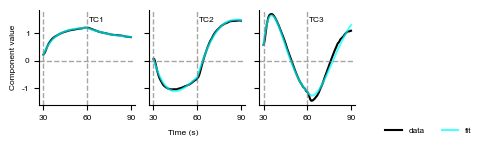

In [29]:
plot_sim_vs_data(C, Csim, save=False, fontsize=font_size_mid)

In [30]:
A

array([[-0.1436146 , -0.01091785, -0.00260134],
       [ 0.16666958, -0.03354784, -0.02570792],
       [-0.60605769,  0.08219366, -0.08171684]])

## Extended Fig. 5a

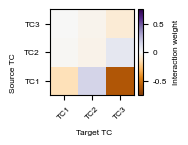

In [31]:
figsize = mm_to_inches((single_column*0.5, max_height/5))
f, ax = plt.subplots(figsize=figsize, layout='constrained')
cb = ax.pcolormesh(A.T, vmin=-0.75, vmax=0.75, cmap='PuOr')
ax.set_xticks(np.arange(r)+0.5, [f'TC{i+1}' for i in range(r)], rotation=45, fontsize=font_size_mid)
ax.set_yticks(np.arange(r)+0.5, [f'TC{i+1}' for i in range(r)], fontsize=font_size_mid)
# utils.simpleaxis(ax)
cbar = f.colorbar(cb, ax=ax)
cbar.ax.tick_params(labelsize=font_size_mid)
cbar.set_label('Interaction weight', fontsize=font_size_mid)
cbar.ax.set_yticks([-0.5, 0, 0.5], [-0.5, 0, 0.5], fontsize=font_size_mid)
f.supxlabel("Target TC", fontsize=font_size_mid)
f.supylabel("Source TC", fontsize=font_size_mid)
# plt.savefig("figures/lds_A_matrix.svg", bbox_inches='tight', transparent=True)
plt.show()

In [32]:
plt.close('all')

## Extended Fig. 5b,c

6.098015954220614
21.07669895658939
21.07669895658939
0.1413548262337308 0.16339900405491037
-0.20024948269126094 -0.07031522904016853
0.5903507125650517 0.6310375870771596


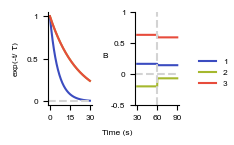

In [33]:
vals, vecs = np.linalg.eig(A)
taus = -1/np.real(vals)
time = np.linspace(0,T*dt,T)
#nice bright clearly distinguishable pastel colors here
# cols = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']
cols = ["#c2c2c2", "#8A8A8A", "#1D1D1D"]
cols = ["#3B4CC0", "#A5B82E", "#E74C3C"]
figsize = mm_to_inches((single_column*0.63, max_height/5))
# time = time[:15]
f, ax = plt.subplots(1, 2, figsize=figsize, layout='constrained')

lines = []
for j, t in enumerate(taus):
    line, = ax[0].plot(time/2, np.exp(-time/(2*t)), label=f'{j+1}', color=cols[j])
    ax[0].set_yticks([0, 0.5, 1], [0, 0.5, 1], fontsize=font_size_mid)
    ax[0].set_xticks([0, 15, 30], [0, 15, 30], fontsize=font_size_mid)
    lines.append(line)
    print(t)

for j, (b_op, b_pa) in enumerate(B):
    # beta_vec = [b_pa]*(len(time)//2) + [b_op]*(len(time)//2)
    # beta_vec = b_pa*u_PA + b_op*u_OP
    beta_vec = b_pa*u_pa + b_op*u_op 
    # beta_vec = 1*u_PA + 1*u_OP
    ax[1].plot(time, beta_vec, label=f'Beta {j}', color=cols[j])
    print(np.min(beta_vec), np.max(beta_vec))
    
for a in ax:
    a.axhline(y=0, linestyle='--', color='lightgray')
    utils.simpleaxis(a)

yticks = [-0.5,0,0.5,1]
for a in ax[1:]:
    a.set_xticks([0,30,60], [30,60,90], fontsize=font_size_mid)
    a.set_yticks(yticks, yticks, fontsize=font_size_mid)
    a.axvline(x=30, linestyle='--', color='lightgray')
ax[0].set_ylabel('exp(-t/ $\\tau$)', fontsize=font_size_mid)
ax[1].set_ylabel('B', fontsize=font_size_mid, rotation=0)
f.supxlabel("Time (s)", fontsize=font_size_mid)
f.legend(handles=lines, loc='outside center right', frameon=False, fontsize=font_size_mid)
# plt.savefig("figures/model_parameters.svg", bbox_inches='tight', transparent=True)
plt.show()

In [34]:
def pool_projected_neurons_torch(projected, all_neurs_set, masks=None, cond_order=("naive", "trained")):
    pooled = {}

    for genotype in projected:
        pooled.setdefault(genotype, {})
        for promoter in projected[genotype]:
            for stimulus in projected[genotype][promoter]:
                pooled[genotype].setdefault(stimulus, {})

                W_naive_full = None
                if masks is not None and cond_order[0] in projected[genotype][promoter][stimulus]:
                    W_naive_full = projected[genotype][promoter][stimulus][cond_order[0]].shape[2]

                for cond in projected[genotype][promoter][stimulus]:
                    pooled[genotype][stimulus].setdefault(cond, {})

                    X = projected[genotype][promoter][stimulus][cond]  # (N,T,W_cond) torch
                    N, T, W_cond = X.shape

                    for nind in range(N):
                        neur = all_neurs_set[genotype][promoter][stimulus][nind]
                        pooled[genotype][stimulus][cond].setdefault(neur, [])

                        Xi = X[nind, :, :]  # (T,W_cond)

                        if masks is not None:
                            Mi_full = masks[genotype][promoter][stimulus][nind, :, :]  # (T,W_all)
                            print(Mi_full.shape, Xi.shape)

                            if cond == cond_order[0]:
                                start = 0
                            elif cond == cond_order[1]:
                                if W_naive_full is None:
                                    raise ValueError("Cannot infer W_naive_full for trained slicing.")
                                start = W_naive_full
                            else:
                                raise ValueError(f"Unknown cond='{cond}'.")

                            Mi = Mi_full[:, start:start + W_cond]      # (T,W_cond)
                            keep_cols = Mi.any(dim=0)                # (W_cond,)
                            Xi = Xi[:, keep_cols]                     # (T,W_kept)

                            if Xi.shape[1] == 0:
                                continue
                        pooled[genotype][stimulus][cond][neur] += Xi

    return pooled

In [35]:
from tensorly import tensor
projected = {}
for genotype in worm_tensors_stimonly:
    projected[genotype] = {}
    for promoter in worm_tensors_stimonly[genotype]:
        projected[genotype][promoter] = {}
        for stimulus in worm_tensors_stimonly[genotype][promoter]:
            if not stimulus in common_temporal_basis[genotype].keys():
                continue
            if not stimulus in projected[genotype].keys():
                projected[genotype][promoter][stimulus] = {}
            for cond in conds:
                if cond not in projected[genotype][promoter][stimulus].keys():
                    projected[genotype][promoter][stimulus][cond] = {}
                
                    print(genotype, promoter, stimulus, cond)
                    
                    if cond in worm_tensors_stimonly[genotype][promoter][stimulus].keys():
                        print(cond, worm_tensors_stimonly[genotype][promoter][stimulus][cond].shape)
                        data_tl = tensor(worm_tensors_stimonly[genotype][promoter][stimulus][cond]).float()
                        temporal_basis = common_temporal_basis[genotype][stimulus].float()
                        projected[genotype][promoter][stimulus][cond] = mode_dot(data_tl, temporal_basis.T, mode=1) 
                        print("Projected shape:", projected[genotype][promoter][stimulus][cond].shape, masks[genotype][promoter][stimulus].shape)

N2 ncs-1 OP-PA-OP naive
naive (15, 300, 19)
Projected shape: torch.Size([15, 6, 19]) torch.Size([15, 300, 39])
N2 ncs-1 OP-PA-OP trained
trained (15, 300, 20)
Projected shape: torch.Size([15, 6, 20]) torch.Size([15, 300, 39])
N2 ncs-1 OP-Buffer-OP naive
naive (12, 300, 14)
Projected shape: torch.Size([12, 6, 14]) torch.Size([12, 300, 31])
N2 ncs-1 OP-Buffer-OP trained
trained (12, 300, 17)
Projected shape: torch.Size([12, 6, 17]) torch.Size([12, 300, 31])
N2 ncs-1 Buffer-PA-Buffer naive
naive (16, 300, 20)
Projected shape: torch.Size([16, 6, 20]) torch.Size([16, 300, 41])
N2 ncs-1 Buffer-PA-Buffer trained
trained (16, 300, 21)
Projected shape: torch.Size([16, 6, 21]) torch.Size([16, 300, 41])
N2 ncs-1 Buffer-Buffer-Buffer naive
naive (12, 300, 10)
Projected shape: torch.Size([12, 6, 10]) torch.Size([12, 300, 20])
N2 ncs-1 Buffer-Buffer-Buffer trained
trained (12, 300, 10)
Projected shape: torch.Size([12, 6, 10]) torch.Size([12, 300, 20])
N2 ncs-1 OP-gacA-OP naive
naive (14, 300, 14)
Pr

In [36]:
pooled_projected = pool_projected_neurons_torch(projected, all_neurs_set, masks=masks)

torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([

## Make half-violinplots

In [37]:
w = utils.makeWorm()
nn_lr = w.networks['Neutral']
nn = utils.foldLeftRight(nn_lr, exceptions=['ASEL', 'ASER'])

In [38]:
from matplotlib.patches import Polygon
from scipy.stats import gaussian_kde

def half_violinplot(ax, data, position, side='right', width=0.8, bw_method=None,
                    color='C0', alpha=0.6, edgecolor='black'):
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    if len(data) < 2:
        return 0,0  # nothing drawn, return 0 height

    kde = gaussian_kde(data, bw_method=bw_method)
    ymin, ymax = data.min(), data.max()
    y = np.linspace(ymin, ymax, 200)
    density = kde(y)
    density = density / density.max() * (width / 2)

    x = position + density if side == 'right' else position - density
    verts = np.column_stack([x, y])
    verts = np.concatenate([
        [[position, y[0]]],
        verts,
        [[position, y[-1]]]
    ])
    poly = Polygon(verts, facecolor=color, edgecolor=edgecolor, alpha=alpha)
    ax.add_patch(poly)

    return y.min(), y.max()  # return actual y limit

In [39]:
def full_data_permutation_diff(group1, group2, central_func: Callable = np.median, n_perm: int = 20000, two_sided: bool = True, random_state=cedne.RANDOM_SEED) -> Dict[str, Any]:
    """Permutation test using ALL data (no truncation) on central tendency difference.
    Returns p-value and effect; p-value inherently reflects sample size (more power for large n).
    """
    rng = np.random.default_rng(random_state)
    g1 = np.asarray(group1); g2 = np.asarray(group2)
    g1 = g1[~np.isnan(g1)]; g2 = g2[~np.isnan(g2)]
    if len(g1) == 0 or len(g2) == 0:
        return {'effect': np.nan, 'pval': np.nan, 'n1': len(g1), 'n2': len(g2)}
    obs = central_func(g1) - central_func(g2)
    combined = np.concatenate([g1, g2])
    n1 = len(g1)
    perm_stats = []
    for _ in range(n_perm):
        rng.shuffle(combined)
        perm_stats.append(central_func(combined[:n1]) - central_func(combined[n1:]))
    perm_stats = np.asarray(perm_stats)
    if two_sided:
        pval = (np.sum(np.abs(perm_stats) >= abs(obs)) + 1) / (len(perm_stats) + 1)
    else:
        pval = (np.sum(perm_stats >= obs) + 1) / (len(perm_stats) + 1) if obs >= 0 else (np.sum(perm_stats <= obs) + 1) / (len(perm_stats) + 1)
    return {'effect': obs, 'pval': pval, 'perm_stats': perm_stats, 'n1': len(g1), 'n2': len(g2)}

def get_sig_neurs(trial_dict, trial_dict_names, periods, common_neurs, sample_size, pval_thres=0.05, replace=False):
    sig_neur = {period:[] for period in periods}
    len_ns = {}
    for period in periods:
        by_neuron_periods = {n: {cond: [] for cond in conditions} for n in common_neurs}
        for cond in conditions:
            for w in trial_dict_names[cond][period].keys(): 
                for m, t in zip(trial_dict_names[cond][period][w], trial_dict[cond][period][w]):
                    if m in common_neurs:
                        by_neuron_periods[m][cond].append(t)
        
        sig_neur[period] = []
        pvalues = []
        for n in by_neuron_periods:
            # print(n, period, by_neuron_periods[n][conditions[0]])
            # kst = ss.ks_2samp(np.median(np.log(by_neuron_periods[n][conditions[0]]), axis=1), np.median(by_neuron_periods[n][conditions[1]], axis=1))
            medians_naive = np.median(by_neuron_periods[n][conditions[0]], axis=1)
            medians_trained = np.median(by_neuron_periods[n][conditions[1]], axis=1)
            if not replace:
                if not len(medians_naive)>sample_size and len(medians_trained)>sample_size:
                    print(f"Sample size not enough for {n}")
                    continue
            #permt = compare_central_tendency_subsampled(medians_naive, medians_trained, n_subsamples=1000, n_shuffle=100, sample_size=sample_size, central_func=np.mean, replace=replace)
            permt = full_data_permutation_diff(medians_naive, medians_trained, central_func=np.mean, random_state=RAND)
            # kst = ss.ttest_ind(np.mean(by_neuron_periods[n][conditions[0]], axis=1), np.mean(by_neuron_periods[n][conditions[1]], axis=1))
            # print(n, period, kst)
            pvalues.append(permt['pval'])
            # print(n, period, len(by_neuron_periods[n][conditions[0]]), len(by_neuron_periods[n][conditions[1]]), permt['pval'])
            len_ns[n] = min(len(by_neuron_periods[n][conditions[0]]), len(by_neuron_periods[n][conditions[1]]))
        _, pvalues, _, _  = multipletests(pvalues, method='fdr_bh')
        sig_neur[period] = [common_neurs[j] for j in np.where(np.array(pvalues)<pval_thres)[0]]
    return sig_neur, len_ns

In [40]:
def add_break_if_clipped_violin(ax, mark_size=0.005, lw=1.0, color='k'):
    ymin, ymax = ax.get_ylim()
    clipped_top = False
    clipped_bot = False

    # half_violinplot added Polygon patches via ax.add_patch(...)
    for p in ax.patches:
        if isinstance(p, Polygon):
            # vertices in data coords (default transform = ax.transData)
            y = p.get_xy()[:, 1]
            if np.any(y > ymax): clipped_top = True
            if np.any(y < ymin): clipped_bot = True

    kwargs = dict(transform=ax.transAxes, color=color, clip_on=False, lw=lw)
    d = mark_size

    if clipped_top:
        ax.plot((-d, +d), (1-d, 1+d), **kwargs)      # top-left slash
        # ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)    # top-right slash
    if clipped_bot:
        ax.plot((-d, +d), (-d, +d), **kwargs)        # bottom-left slash
        # ax.plot((1-d, 1+d), (-d, +d), **kwargs)      # bottom-right slash
            
def plot_component_split_violin(data, ncomps, color_conds, conds, pval_thres=0.05, title='', neuron_filter = [], compare=False, save=''):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import torch
    from scipy import stats as ss
    from statsmodels.stats.multitest import multipletests

    # Sort neurons by type and alphabetically within each type
    neuron_order = ('sensory', 'interneuron', 'motorneuron')
    type_order_map = {typ: i for i, typ in enumerate(neuron_order)}

    if not neuron_filter:
        all_neurons = sorted(
            data[conds[0]].keys(),
            key=lambda n: (type_order_map.get(nn.neurons[n].type, float('inf')), n)
        )
    else:
        all_neurons = list(set(neuron_filter).intersection(data[conds[0]].keys()))
        all_neurons = sorted(
            all_neurons,
            key=lambda n: (type_order_map.get(nn.neurons[n].type, float('inf')), n))

    # Determine where to draw separating lines
    separation_indices = [i for i, (a, b) in enumerate(zip(all_neurons[:-1], all_neurons[1:]), 1)
                          if nn.neurons[a].type != nn.neurons[b].type]
    if len(all_neurons)<20:
        figsize = mm_to_inches((single_column, max_height/3)) #(max(8, len(all_neurons) * 0.4), 3 * ncomps)
    else:
        figsize = mm_to_inches((double_column, max_height/3)) #(max(10, len(all_neurons) * 0.4), 2.5 * ncomps)
    fig, axes = plt.subplots(
        ncomps, 1,
        figsize=figsize,
        sharex=True,
        layout='constrained'
    )

    if ncomps == 1:
        axes = [axes]

    new_data = data
    # new_data = {cond: {neuron: {j : torch.cat(data[cond][neuron][j::ncomps]) for j in range(ncomps)} for neuron in all_neurons} for cond in conds}
    for compnum in range(ncomps):
        ax = axes[compnum]
        records = []
        
        for neuron in all_neurons:
            for cond in conds:

                # vals = new_data[cond][neuron][compnum]
                # vals = vals[~torch.isnan(vals)].cpu().numpy()
                
                vals = new_data[cond][neuron][compnum]

                # Coerce to torch tensor (handles numpy arrays, lists, torch tensors)
                if not torch.is_tensor(vals):
                    vals = torch.as_tensor(vals)

                vals = vals[~torch.isnan(vals)].detach().cpu().numpy()

                print(neuron, cond, vals.shape)
                for v in vals:
                    records.append({
                        'neuron': neuron,
                        'neuron-type': nn.neurons[neuron].type,
                        'condition': cond,
                        'value': v,
                        'component': compnum
                    })

        df = pd.DataFrame.from_records(records)
        df['neuron'] = pd.Categorical(df['neuron'], categories=all_neurons, ordered=True)

        # Compute significance (KS test)
        pvals = []
        for neuron in all_neurons:
            x = df[(df['neuron'] == neuron) & (df['condition'] == conds[0])]['value']
            y = df[(df['neuron'] == neuron) & (df['condition'] == conds[1])]['value']
            # stat, p = ss.ks_2samp(x, y)
            stat, p = ss.mannwhitneyu(x, y) # Replace with permutation test.
            pvals.append(p)

        reject, pvals_corr, _, _ = multipletests(pvals, alpha=pval_thres, method='fdr_bh')

        # Plot split violins
        ymax = -np.inf
        ymin = np.inf
        for j, neuron in enumerate(all_neurons):
            v_naive = df[(df['neuron'] == neuron) & (df['condition'] == conds[0])]['value']
            v_trained = df[(df['neuron'] == neuron) & (df['condition'] == conds[1])]['value']

            ymn1, ymx1 = half_violinplot(ax, v_naive, position=j, side='left', color=color_conds[0], edgecolor=color_conds[0])
            ymn2, ymx2 = half_violinplot(ax, v_trained, position=j, side='right', color=color_conds[1], edgecolor=color_conds[1])

            ymax = max(ymax, ymx1, ymx2, v_naive.max(), v_trained.max())
            ymin = min(ymin, ymn1, ymn2, v_naive.min(), v_trained.min())

            if reject[j]:
                val = max(v_naive.max(), v_trained.max())
                ax.text(j, val + 0.05 * abs(val), '*', ha='center', va='bottom', fontsize=font_size_mid)
            print(neuron, len(v_naive), len(v_trained))

        # Aesthetics
        # ax.set_ylabel(f'{compnum + 1}', fontsize=font_size_big, rotation=0)
        ax.set_xticks(range(len(all_neurons)))
        ax.set_xticklabels(all_neurons, rotation=45, fontsize=font_size_mid)
        ax.axhline(0, color='gray', linestyle='--', lw=1)
        ax.set_xlim((-1, len(all_neurons)))

        for idx in separation_indices:
            ax.axvline(idx - 0.5, linestyle='--', color='gray', linewidth=1)

        if ymax > 0:
            ax.set_ylim(top=ymax * 1.1)
        if ymin < 0:
            ax.set_ylim(bottom=ymin * 1.1)
        ax.set_ylim(-30,30)

        utils.simpleaxis(ax)
    d = .005
    axes[-1].set_xlabel("Neuron", fontsize=font_size_mid)
    for ax in axes:
        ax.tick_params(axis='y', labelsize=font_size_mid)
        add_break_if_clipped_violin(ax)
    fig.supylabel("Projected activity", fontsize=font_size_mid)
    fig.suptitle(title, fontsize=font_size_mid)
    if save:
        plt.savefig(save, transparent=True, dpi=600)
        plt.show()
    else:
        plt.show()

    if not compare:
        return
    else:
        plot_component_split_violin(compare, ncomps, color_conds, conds, pval_thres=0.05, title='N2-OP-PA-OP', neuron_filter = all_neurons, compare=False, save='')

## Fig. 2c,d; Extended Data Fig. 5 d-h

Genotype: N2
Stimulus: OP-PA-OP
ADF naive (13,)
ADF trained (17,)
AFD naive (19,)
AFD trained (20,)
ASEL naive (16,)
ASEL trained (19,)
ASER naive (17,)
ASER trained (16,)
ASG naive (17,)
ASG trained (20,)
ASH naive (9,)
ASH trained (12,)
ASI naive (17,)
ASI trained (15,)
AWA naive (16,)
AWA trained (18,)
AWB naive (19,)
AWB trained (20,)
AWC naive (19,)
AWC trained (20,)
BAG naive (19,)
BAG trained (20,)
CEPD naive (12,)
CEPD trained (18,)
CEPV naive (17,)
CEPV trained (21,)
FLP naive (21,)
FLP trained (22,)
IL1 naive (22,)
IL1 trained (19,)
IL1D naive (22,)
IL1D trained (19,)
IL1V naive (22,)
IL1V trained (19,)
OLL naive (19,)
OLL trained (18,)
URYD naive (20,)
URYD trained (22,)
URYV naive (19,)
URYV trained (20,)
ADA naive (22,)
ADA trained (23,)
AIB naive (21,)
AIB trained (21,)
AIM naive (23,)
AIM trained (22,)
AIN naive (21,)
AIN trained (23,)
AIZ naive (21,)
AIZ trained (21,)
ALA naive (17,)
ALA trained (21,)
AVA naive (25,)
AVA trained (22,)
AVB naive (20,)
AVB trained (19,)
A

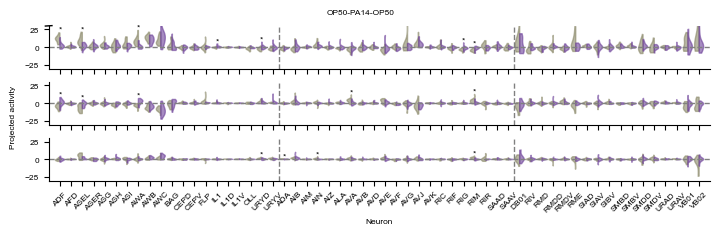

Stimulus: OP-Buffer-OP
ADF naive (13,)
ADF trained (13,)
AFD naive (11,)
AFD trained (16,)
ASEL naive (12,)
ASEL trained (11,)
ASER naive (11,)
ASER trained (14,)
ASG naive (13,)
ASG trained (17,)
ASI naive (7,)
ASI trained (12,)
AWA naive (13,)
AWA trained (12,)
AWB naive (14,)
AWB trained (16,)
AWC naive (14,)
AWC trained (16,)
BAG naive (12,)
BAG trained (16,)
OLL naive (11,)
OLL trained (14,)
SAAV naive (12,)
SAAV trained (14,)
ADF 13 13
AFD 11 16
ASEL 12 11
ASER 11 14
ASG 13 17
ASI 7 12
AWA 13 12
AWB 14 16
AWC 14 16
BAG 12 16
OLL 11 14
SAAV 12 14
ADF naive (13,)
ADF trained (13,)
AFD naive (11,)
AFD trained (16,)
ASEL naive (12,)
ASEL trained (11,)
ASER naive (11,)
ASER trained (14,)
ASG naive (13,)
ASG trained (17,)
ASI naive (7,)
ASI trained (12,)
AWA naive (13,)
AWA trained (12,)
AWB naive (14,)
AWB trained (16,)
AWC naive (14,)
AWC trained (16,)
BAG naive (12,)
BAG trained (16,)
OLL naive (11,)
OLL trained (14,)
SAAV naive (12,)
SAAV trained (14,)
ADF 13 13
AFD 11 16
ASEL 12 1

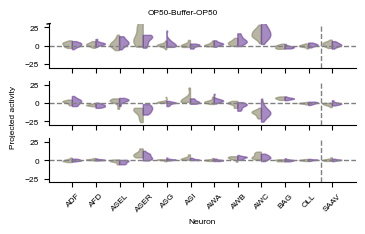

Stimulus: Buffer-PA-Buffer
ADF naive (18,)
ADF trained (17,)
AFD naive (20,)
AFD trained (19,)
ASEL naive (13,)
ASEL trained (14,)
ASER naive (15,)
ASER trained (10,)
ASG naive (19,)
ASG trained (21,)
ASH naive (10,)
ASH trained (11,)
ASI naive (16,)
ASI trained (16,)
AWA naive (18,)
AWA trained (18,)
AWB naive (19,)
AWB trained (21,)
AWC naive (20,)
AWC trained (21,)
BAG naive (20,)
BAG trained (19,)
CEPD naive (14,)
CEPD trained (15,)
CEPV naive (14,)
CEPV trained (17,)
FLP naive (14,)
FLP trained (15,)
IL1 naive (22,)
IL1 trained (17,)
IL1D naive (22,)
IL1D trained (17,)
IL1V naive (22,)
IL1V trained (17,)
OLL naive (18,)
OLL trained (20,)
URYD naive (15,)
URYD trained (15,)
URYV naive (15,)
URYV trained (17,)
ADA naive (20,)
ADA trained (20,)
AIB naive (23,)
AIB trained (24,)
AIM naive (15,)
AIM trained (18,)
AIN naive (19,)
AIN trained (21,)
AIZ naive (22,)
AIZ trained (23,)
ALA naive (15,)
ALA trained (14,)
AVA naive (19,)
AVA trained (23,)
AVB naive (16,)
AVB trained (20,)
AVD n

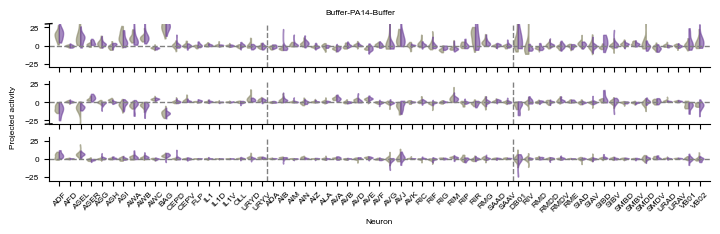

Stimulus: Buffer-Buffer-Buffer
ADF naive (9,)
ADF trained (10,)
AFD naive (10,)
AFD trained (10,)
ASEL naive (10,)
ASEL trained (9,)
ASER naive (8,)
ASER trained (9,)
ASG naive (10,)
ASG trained (10,)
AWA naive (10,)
AWA trained (9,)
AWB naive (10,)
AWB trained (10,)
AWC naive (10,)
AWC trained (10,)
BAG naive (10,)
BAG trained (10,)
CEPD naive (10,)
CEPD trained (9,)
CEPV naive (10,)
CEPV trained (10,)
FLP naive (10,)
FLP trained (9,)
IL1 naive (9,)
IL1 trained (12,)
IL1D naive (9,)
IL1D trained (11,)
IL1V naive (11,)
IL1V trained (12,)
OLL naive (8,)
OLL trained (9,)
URYD naive (10,)
URYD trained (10,)
URYV naive (9,)
URYV trained (10,)
ADA naive (10,)
ADA trained (9,)
AIB naive (10,)
AIB trained (12,)
AIM naive (9,)
AIM trained (8,)
AIN naive (10,)
AIN trained (9,)
AIZ naive (10,)
AIZ trained (10,)
ALA naive (9,)
ALA trained (8,)
AVA naive (10,)
AVA trained (10,)
AVB naive (10,)
AVB trained (8,)
AVD naive (8,)
AVD trained (7,)
AVE naive (10,)
AVE trained (10,)
AVF naive (7,)
AVF tra

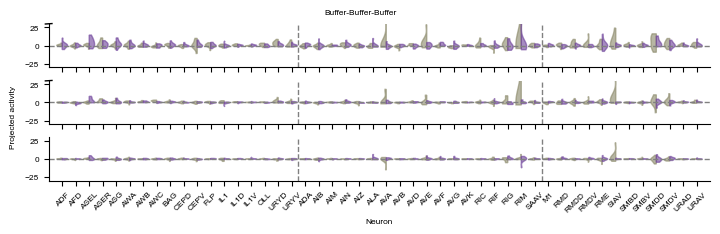

Stimulus: OP-gacA-OP
ADF naive (11,)
ADF trained (9,)
AFD naive (13,)
AFD trained (12,)
ASEL naive (11,)
ASEL trained (13,)
ASER naive (13,)
ASER trained (12,)
ASG naive (14,)
ASG trained (15,)
ASI naive (10,)
ASI trained (11,)
AWA naive (8,)
AWA trained (13,)
AWB naive (13,)
AWB trained (16,)
AWC naive (14,)
AWC trained (16,)
BAG naive (14,)
BAG trained (16,)
OLL naive (9,)
OLL trained (13,)
AVK naive (8,)
AVK trained (14,)
SAAD naive (9,)
SAAD trained (13,)
SAAV naive (11,)
SAAV trained (13,)
ADF 11 9
AFD 13 12
ASEL 11 13
ASER 13 12
ASG 14 15
ASI 10 11
AWA 8 13
AWB 13 16
AWC 14 16
BAG 14 16
OLL 9 13
AVK 8 14
SAAD 9 13
SAAV 11 13
ADF naive (11,)
ADF trained (9,)
AFD naive (13,)
AFD trained (12,)
ASEL naive (11,)
ASEL trained (13,)
ASER naive (13,)
ASER trained (12,)
ASG naive (14,)
ASG trained (15,)
ASI naive (10,)
ASI trained (11,)
AWA naive (8,)
AWA trained (13,)
AWB naive (13,)
AWB trained (16,)
AWC naive (14,)
AWC trained (16,)
BAG naive (14,)
BAG trained (16,)
OLL naive (9,)
OLL 

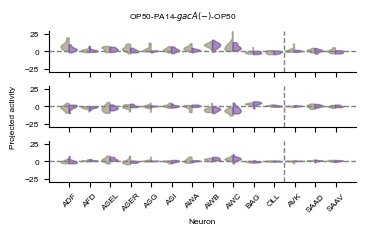

Genotype: inx-7-mutant
Stimulus: OP-PA-OP
ADF naive (17,)
ADF trained (11,)
AFD naive (17,)
AFD trained (14,)
ASEL naive (14,)
ASEL trained (12,)
ASER naive (15,)
ASER trained (15,)
ASG naive (16,)
ASG trained (15,)
ASH naive (9,)
ASH trained (7,)
ASI naive (13,)
ASI trained (9,)
AWA naive (16,)
AWA trained (13,)
AWB naive (17,)
AWB trained (15,)
AWC naive (17,)
AWC trained (15,)
BAG naive (16,)
BAG trained (14,)
OLL naive (17,)
OLL trained (15,)
AVK naive (15,)
AVK trained (14,)
SAAD naive (14,)
SAAD trained (13,)
SAAV naive (17,)
SAAV trained (14,)
ADF 17 11
AFD 17 14
ASEL 14 12
ASER 15 15
ASG 16 15
ASH 9 7
ASI 13 9
AWA 16 13
AWB 17 15
AWC 17 15
BAG 16 14
OLL 17 15
AVK 15 14
SAAD 14 13
SAAV 17 14
ADF naive (17,)
ADF trained (11,)
AFD naive (17,)
AFD trained (14,)
ASEL naive (14,)
ASEL trained (12,)
ASER naive (15,)
ASER trained (15,)
ASG naive (16,)
ASG trained (15,)
ASH naive (9,)
ASH trained (7,)
ASI naive (13,)
ASI trained (9,)
AWA naive (16,)
AWA trained (13,)
AWB naive (17,)
AWB

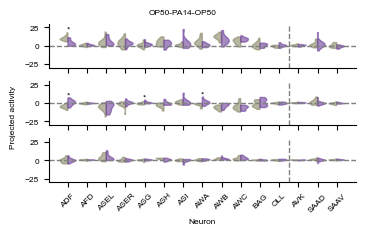

Genotype: inx-7-rescue
Stimulus: OP-PA-OP
ADF naive (16,)
ADF trained (11,)
AFD naive (18,)
AFD trained (15,)
ASEL naive (10,)
ASEL trained (11,)
ASER naive (17,)
ASER trained (15,)
ASG naive (18,)
ASG trained (15,)
ASH naive (13,)
ASH trained (9,)
ASI naive (17,)
ASI trained (9,)
AWA naive (16,)
AWA trained (15,)
AWB naive (18,)
AWB trained (15,)
AWC naive (18,)
AWC trained (15,)
BAG naive (17,)
BAG trained (15,)
OLL naive (18,)
OLL trained (15,)
AIY naive (9,)
AIY trained (6,)
AVK naive (14,)
AVK trained (13,)
RMG naive (13,)
RMG trained (10,)
SAAD naive (13,)
SAAD trained (15,)
SAAV naive (17,)
SAAV trained (15,)
ADF 16 11
AFD 18 15
ASEL 10 11
ASER 17 15
ASG 18 15
ASH 13 9
ASI 17 9
AWA 16 15
AWB 18 15
AWC 18 15
BAG 17 15
OLL 18 15
AIY 9 6
AVK 14 13
RMG 13 10
SAAD 13 15
SAAV 17 15
ADF naive (16,)
ADF trained (11,)
AFD naive (18,)
AFD trained (15,)
ASEL naive (10,)
ASEL trained (11,)
ASER naive (17,)
ASER trained (15,)
ASG naive (18,)
ASG trained (15,)
ASH naive (13,)
ASH trained (9,)

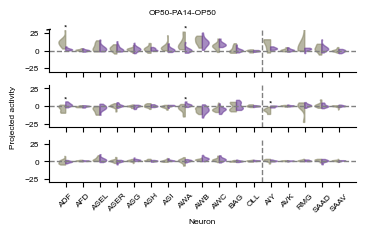

In [41]:
for genotype in pooled_projected:
    print("Genotype:", genotype)
    for stimulus in pooled_projected[genotype]:
        print("Stimulus:", stimulus)
        if stimulus == 'OP-PA-OP':
            stimlabel = 'OP50-PA14-OP50'
        elif stimulus == 'Buffer-PA-Buffer':
            stimlabel = 'Buffer-PA14-Buffer'
        elif stimulus == 'OP-Buffer-OP':
            stimlabel = 'OP50-Buffer-OP50'
        elif stimulus == 'OP-gacA-OP':
            stimlabel = "OP50-PA14-$\\it{gacA(-)}$-OP50"
        else:
            stimlabel = stimulus
        plot_component_split_violin(
            data=pooled_projected[genotype][stimulus],
            ncomps=3,
            color_conds=[color_conds['naive'], color_conds['trained']],  # naive, trained
            conds=['naive', 'trained'],
            pval_thres=0.05,
            title=f'{stimlabel}',
            # compare = pooled_projected['N2']['OP-PA-OP'],
            # save=f'{outputDir}{genotype}_{stimulus}_neurons_tucker.svg'
        )